# Temporal spectra and decorrelations


In [29]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt

import numpy as np
import xarray as xr

from scipy import signal

import crocosi.postp as pp

In [2]:
from dask.distributed import Client, LocalCluster
#
#cluster = LocalCluster()
#
from dask_jobqueue import PBSCluster
cluster = PBSCluster()
w = cluster.scale(28*2)
#
client = Client(cluster)
client

Client Scheduler: tcp://10.148.1.47:34506 Dashboard: http://10.148.1.47:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


## Load data

In [3]:
#root_path = '/home1/scratch/aponte/'
root_path = '/home/c11-data/Test_aponte/jetn/'
run = 'jet_cfg1_wp75_4km_1500a2000j_itide/'

#r = pp.Run(root_path+run, prefix='file_', open_nc=['surf'], verbose=True)
r = pp.Run(root_path+run, open_nc=['surf'], tdir_max=2, verbose=True)
r['surf'] = r['surf'].rename({'time_instant': 'time'})

Analysing directory /home/c11-data/Test_aponte/jetn/jet_cfg1_wp75_4km_1500a2000j_itide/
Found 2 segments
Found 2 grid files
Found 4 surf files
Detected time step of 300.0 s
Detected theta_s = 5.0
Detected theta_b = 0.0
Detected Hc = 100.0 m
Detected rho0 = 1000.0 kg/m^3
Detected H = 4000.0 m
Found 9 columns in output.mpi:
['STEP', 'time[DAYS]', 'KINETIC_ENRG', 'POTEN_ENRG', 'TOTAL_ENRG', 'NET_VOLUME', 'trd', 'ENSTROPHY', 'BTKIN_ENRG']
Opening NC datasets:  ['grid', 'surf']
Grid size: (L ,M, N) = (258, 722, 50)


In [4]:
#r['surf']

In [5]:
V = ['u', 'v']
dij = 4
dti = 3
ds = (r['surf'][V].isel({'x_rho': slice(0,None,dij), 'x_u': slice(0,None,dij),
                         'y_rho': slice(0,None,dij), 'y_v': slice(0,None,dij),
                         'time': slice(0,None,dti)})
     ).squeeze()
print('dataset size: %.0f GB' %(ds.nbytes/1e9))

dataset size: 1 GB


In [ ]:
ds

In [7]:
x, y, t = 10, 10, 6*24*20
ds = ds.chunk({'time': t, 'x_rho': x, 'x_u': x, 'y_rho': y, 'y_v': y})

In [8]:
ds = ds.persist()

---

## Spectra: manual computation

In [17]:
# utility functions

def get_spectra(x, fs=None, ufunc=True, **kwargs):
    ax = -1 if ufunc else 0
    #
    dkwargs = {'window': 'hann', 'return_onesided': False, 
               'detrend': 'linear', 'scaling': 'density'}
    dkwargs.update(kwargs)
    f, E = signal.welch(x, fs=fs, axis=ax, **dkwargs)
    #
    if ufunc:
        return E
    else:
        return f, E

def wrap_spectra(v, dt, f=None, **kwargs):
    v = v.chunk({'time': -1})
    _kwargs = {'fs': 1./dt}
    _kwargs.update(kwargs)
    if f is None:
        f, E = get_spectra(v.values, ufunc=False, **_kwargs)
        return f, E
    else:
        E = xr.apply_ufunc(get_spectra, v,
                    dask='parallelized', output_dtypes=[np.float64],
                    input_core_dims=[['time']],
                    output_core_dims=[['freq_time']],
                    output_sizes={'freq_time': _kwargs['nperseg']}, kwargs=_kwargs)
        return E.assign_coords(freq_time=f).sortby('freq_time')

In [18]:
dt = float((ds.time[1]-ds.time[0]).values)
N = int(20/dt)
f, _ = wrap_spectra(ds.u.isel(x_u=0,y_rho=0), dt, nperseg=N)
E = wrap_spectra(ds.u, dt, f=f, nperseg=N)
E

In [20]:
E_mean = E.mean('x_u').persist()

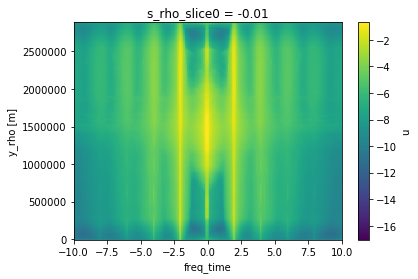

In [21]:
np.log10(E_mean).plot(x='freq_time', xlim=(-10,10))

---

## Spectra: xrft

---

## Decorrelations: manual apply_ufunc

In [30]:
# utility functions

def correlate(v1, v2, dt=None, roll=False, detrend=True, ufunc=True, **kwargs):
    ''' Compute a lagged correlation between two time series
    These time series are assumed to be regularly sampled in time 
    and along the same time line.
    
    Parameters
    ----------
    
        v1, v2: ndarray, pd.Series
            Time series to correlate, the index must be time if dt is not provided
            
        dt: float, optional
            Time step
            
        detrend: boolean, optional
            Turns detrending on or off. Default is False.

    See: https://docs.scipy.org/doc/numpy/reference/generated/numpy.correlate.html
    '''
    
    assert v1.shape == v2.shape
    
    if not ufunc:
        v1 = v1.transpose((2,1,0))
        v2 = v2.transpose((2,1,0))
    
    if detrend and not roll:
        v1 = signal.detrend(v1)
        v2 = signal.detrend(v2)
        _correlate = np.correlate
        _kwargs = {'mode': 'same'}
        N = int(v1.shape[-1]/2)
    else:
        _correlate = roll_correlate
        _kwargs = {'mode': 'same', 'detrend': detrend}
    _kwargs.update(**kwargs)
    
    # loop over all dimensions but the last one to apply correlate
    Ni = v1.shape[:-1]
    # infer number of lags from dummy computation
    i0 = tuple(0 for i in Ni) + np.s_[:,]
    f = _correlate(v1[i0], v2[i0], **_kwargs)
    vv = np.full(Ni+f.shape, np.NaN)
    for ii in np.ndindex(Ni):
        f = _correlate(v1[ii + np.s_[:,]], v2[ii + np.s_[:,]], **_kwargs)
        Nj = f.shape
        for jj in np.ndindex(Nj):
            vv[ii + jj] = f[jj]
    
    # select only positive lags
    vv = vv[...,int(vv.shape[-1]/2):]
    
    if ufunc:
        return vv
    else:
        lags = np.arange(vv.shape[-1])*dt
        vv = vv.transpose((2,1,0))
        return lags, vv

def roll_correlate(v1, v2, Nr=None, overlap=0., detrend=None, **kwargs):
    ''' Correlation over temporal windows of size Nr with overlap
    '''
    i=0
    C=[]
    while i+Nr<v1.size:
        _v1 = v1[i:i+Nr]
        _v2 = v2[i:i+Nr]
        if detrend:
            _v1 = signal.detrend(_v1)
            _v2 = signal.detrend(_v2)
        C+=[np.correlate(_v1, _v2, **kwargs)]
        i+=int((1-overlap)*Nr)
    return np.mean(np.stack(C), axis=0)
    
# quick tests
#v1 = ds.u.isel(x_u=slice(0,10), y_rho=slice(0,10)).values.transpose((1,2,0))
#v1_cor = correlate(v1, v1, dt=1/24/6)
#v1_cor = roll_correlate(v1[0,0,:], v1[0,0,:], Nr=6*24*20, overlap=0)
#v1_cor = correlate(v1, v1, roll=True, Nr=6*24*20, overlap=0)

In [31]:
def wrap_correlate(v1, v2, dt, lags=None, **kwargs):
    v1 = v1.chunk({'time': -1})
    v2 = v2.chunk({'time': -1})
    if lags is None:
        lags, C = correlate(v1.values, v2.values, dt=dt, ufunc=False, **kwargs)
        return lags, C
    else:
        C = xr.apply_ufunc(correlate, v1, v2,
                    dask='parallelized', output_dtypes=[np.float64],
                    input_core_dims=[['time'], ['time']],
                    output_core_dims=[['lags']],
                    output_sizes={'lags': lags.size}, kwargs=kwargs)
        return C.assign_coords(lags=lags).rename('correlation')

In [32]:
dt = float((ds.time[1]-ds.time[0]).values)
_u = ds.u.isel(x_u=slice(0,2),y_rho=slice(0,2))
lags, _ = wrap_correlate(_u, _u, dt, roll=True, Nr=int(20/dt))

In [33]:
Cuu = wrap_correlate(ds.u, ds.u, dt, lags=lags, roll=True, Nr=int(20/dt))
Cuu_mean = Cuu.mean('x_u').persist()

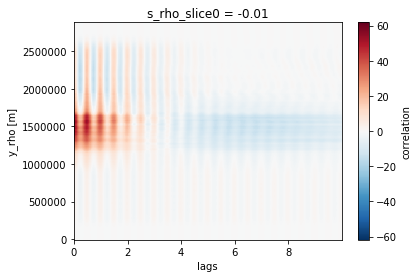

In [34]:
Cuu_mean.plot(x='lags')

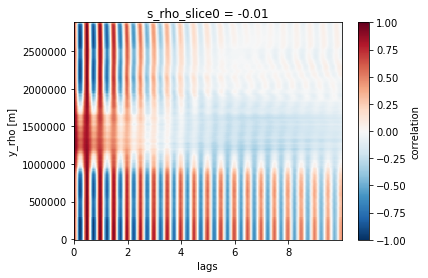

In [35]:
(Cuu_mean/Cuu_mean.sel(lags=0, method='nearest')).plot(x='lags')

---

In [ ]:
cluster.close()